## Shelter Animal Outcomes
#### Explore Data
First I wanted to get familiar with the dataset, so produced various descriptive graphs. I'm taking this rather leisurely, meandering through the data as I please and without particular direction. Ben &lt;3 animals, so this is interesting!

In [2]:
import pandas as pd

data_raw = pd.read_csv('./input/train.csv')

# Print dataframe headers and unique counts
print(data_raw.apply(pd.Series.nunique))

AnimalID          26729
Name               6374
DateTime          22918
OutcomeType           5
OutcomeSubtype       16
AnimalType            2
SexuponOutcome        5
AgeuponOutcome       44
Breed              1380
Color               366
dtype: int64


The first thing which strikes me is five SexuponOutcome values, which seems rather counterintuitive...

In [3]:
print(list(data_raw.SexuponOutcome.unique()))

['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female', 'Unknown', nan]


Ah OK, that makes more sense. Lets split out the traditional sex term and the neutered status, as these are likely to reveal more separately:

In [4]:
# Helpfully taken from Eugenia Uchaeva's 'Take a look at the data' script:
# https://www.kaggle.com/uchayder/shelter-animal-outcomes/take-a-look-at-the-data

def get_sex(element):
    ## Takes string input, searches for sex within string,
    ## returns sex
    element = str(element)
    if element.find('Male') >= 0: return 'male'
    if element.find('Female') >= 0: return 'female'
    return 'unknown'

def get_neutered(element):
    ## Takes string input, searches for neutered status
    ## within string, returns status
    element = str(element)
    if element.find('Spayed') >= 0: return 'neutered'
    if element.find('Neutered') >= 0: return 'neutered'
    if element.find('Intact') >= 0: return 'intact'
    return 'unknown'

data_raw['Sex'] = data_raw.SexuponOutcome.apply(get_sex)
data_raw['NeuteredStatus'] = data_raw.SexuponOutcome.apply(get_neutered)

The next thing which peaks my curiosity is our 44 unique values in AgeuponOutcome. These surely can't be years...

In [5]:
print(list(data_raw.AgeuponOutcome.unique()))

['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years', '3 months', '2 weeks', '2 months', '10 months', '6 months', '5 years', '7 years', '3 years', '4 months', '12 years', '9 years', '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years', '11 months', '4 days', '9 months', '8 months', '15 years', '10 years', '1 week', '0 years', '14 years', '3 days', '6 days', '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan, '17 years', '18 years', '19 years', '20 years']


Didn't think so! Thinking out loud for later: I don't want to mask insights by creating bins which are too large, so I think I'll use months as my unit of age. I reason that years would give too wide a spread - my 9-month old puppy has grown *very* quickly, which wouldn't be caught if I used an annual binning system - but that anything less than months is too precise - for those animals who enter as lost/strays, shelter workers certainly couldn't identify their age at a finer resolution!

Now, for some more visual descriptions...

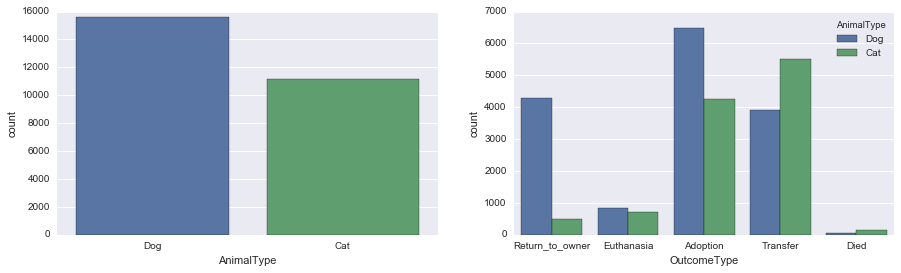

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
# Plot the number of each animal, outcomes by animal type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
sns.countplot(x = data_raw.AnimalType, ax = ax1)
sns.countplot(x = data_raw.OutcomeType, hue = data_raw.AnimalType, ax = ax2)

A little bit naughty to compare outcomes without normalising, but its clear to see dogs are much more frequently returned to their owners than cats. Having had both animals I do not find this too surprising; I'd conjecture that this is due to dogs running off and losing their way home, but without data this is just that - conjecture. Dogs are also most likely to be adopted, whilst cats are more likely to be transferred. I wonder what makes up the sub-types?

In [7]:
print(data_raw.groupby(['OutcomeType','OutcomeSubtype']).size())
n = len(data_raw.AnimalID)
print("Records with sub-type:    %i / %i" % (sum(data_raw.groupby(['OutcomeType','OutcomeSubtype']).size()), n))
print("Records with NaN results: %i / %i" % (data_raw.OutcomeSubtype.isnull().sum(), n))

OutcomeType  OutcomeSubtype     
Adoption     Barn                      1
             Foster                 1800
             Offsite                 165
Died         At Vet                    4
             Enroute                   8
             In Foster                52
             In Kennel               114
             In Surgery                3
Euthanasia   Aggressive              320
             Behavior                 86
             Court/Investigation       6
             Medical                  66
             Rabies Risk              74
             Suffering              1002
Transfer     Barn                      1
             Partner                7816
             SCRP                   1599
dtype: int64
Records with sub-type:    13117 / 26729
Records with NaN results: 13612 / 26729


For the outcomes, there are also most common outcome sub-types. For example, sadly most animals are euthanised due to 'Suffering', and for this particular shelter many animals are transferred to 'Parters'. The least polarised of these is for the 'Died' outcome, which is small in comparison to the rest, but still has a clear sub-type. Also, the sub-types offer an explanation for the high rat of 'transfer' for cats: I just learned that 'SCRP' is an acronym for the Stray Cat Return Program.

Next I wish to look at the number of animals the shelter has been dealing with over time.

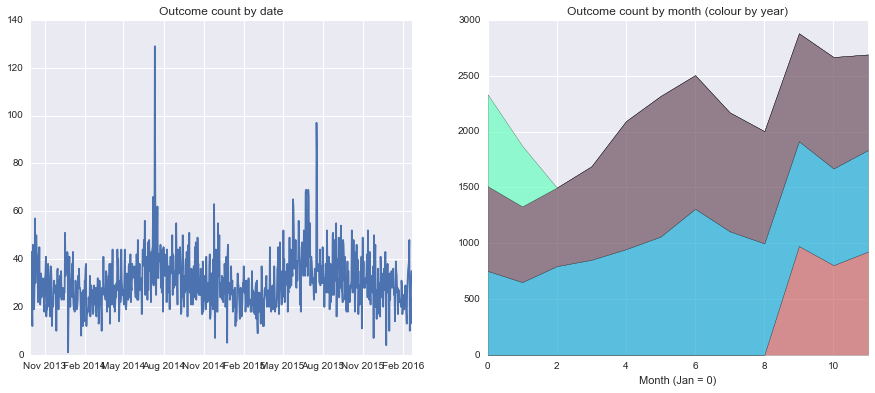

In [71]:
## Plot timeseries of outcomes

# Get month and year from DateTime
data_raw.DateTime = pd.to_datetime(data_raw.DateTime).dt.date

# Hack dates into list of months separated by year for stacked area plot
# I am sure there is a better way of doing this.
outcome_date_tuple = data_raw.DateTime.map(lambda x: [x.month, x.year])
index = ['2013','2014','2015','2016']
columns = ['1','2','3','4','5','6','7','8','9','10','11','12']
outcome_m_y_df = pd.DataFrame(index = index, columns = columns)
outcome_m_y_df = outcome_m_y_df.fillna(0) 

# For each tuple, increment df month / year figure
for element in outcome_date_tuple:
    outcome_m_y_df.loc[str(element[1])][element[0] - 1] += 1

import numpy as np
def create_area_chart(data, ax=None):
    ## Takes a 4x12 dataframe and a set of axes, returns stacked area plot
    if ax is None:
            ax = plt.gca()
    
    y = data.as_matrix()
    x = np.arange(len(y[:][1]))
    y_stack = np.cumsum(y, axis=0)   # a 4x12 array

    ax.fill_between(x, 0, y_stack[0,:], facecolor="#CC6666", alpha=.7)
    ax.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor="#1DACD6", alpha=.7)
    ax.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor="#6E5160", alpha=.7)
    ax.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor="#69FFBF", alpha=.7)

    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(data_raw.AnimalID.groupby(data_raw.DateTime).count())
create_area_chart(outcome_m_y_df, ax2)
ax1.set_title('Outcome count by date')
ax2.set_xlim([0, 11])
ax2.set_title('Outcome count by month (colour by year)')
ax2.set_xlabel('Month (Jan = 0)')

Interesting! It appears there are questionably large spikes of outcomes on two dates, yielding corresponding increases in July and October. I would hazard a guess that the severe spikes on particular dates are artificial, and I'd need to consider removing this anomaly before training any classifier with date as a feature. I can currently find no logical hypothesis for spikes in these months (unwanted Christmas gift return... in July?...) and I'm wondering if it is just an artefact of accounting.

In the by-date plot, we can see that the overriding trend is for a peak in outcomes in late-summer and a trough in late-winter. Although not very clear, a bump in each year's December in discernible.

To be continued!